# In this work, it will use a fine tune a Bert model to do the title detection task. 

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import chardet
import numpy as np
from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader, random_split
import random

# Models

import torch.nn as nn
import torch.nn.functional as F
# from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, BertModel
# Evaluation

from sklearn.metrics import classification_report, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 250921
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 250921


250921

In [560]:
# with open('train_sections_data.csv', 'rb') as f:
#     result_train = chardet.detect(f.read())  # or readline if the file is large
# with open('test_sections_data.csv', 'rb') as f:
#     result_test = chardet.detect(f.read())  # or readline if the file is large
# train_full = pd.read_csv('train_sections_data.csv', encoding=result_train['encoding'])
# test_full = pd.read_csv('test_sections_data.csv', encoding=result_test['encoding'])
# train_full_cleaned = train_full.drop(['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12','FontType'],axis=1)
# test_full_cleaned = test_full.drop(['FontType'],axis=1)
# train_full_cleaned[["IsBold","IsItalic","IsUnderlined"]] = train_full_cleaned[["IsBold","IsItalic","IsUnderlined"]].astype(int)
# test_full_cleaned[["IsBold","IsItalic","IsUnderlined"]] = test_full_cleaned[["IsBold","IsItalic","IsUnderlined"]].astype(int)
# train_cleaned, valid_cleaned = train_test_split(train_full_cleaned, test_size=0.1)
# scaler = preprocessing.StandardScaler().fit(train_cleaned.iloc[:,4:8])
# train_cleaned.iloc[:,4:8] = scaler.transform(train_cleaned.iloc[:,4:8])
# valid_cleaned.iloc[:,4:8] = scaler.transform(valid_cleaned.iloc[:,4:8])
# test_full_cleaned.iloc[:,4:8] = scaler.transform(test_full_cleaned.iloc[:,4:8])
# train_cleaned.to_csv("train_cleaned.csv",index=False)
# valid_cleaned.to_csv("valid_cleaned.csv",index=False)
# test_full_cleaned.to_csv("test_cleaned.csv",index=False)

In [101]:
train, valid, test = pd.read_csv("train_cleaned.csv"),pd.read_csv("valid_cleaned.csv"),pd.read_csv("test_cleaned.csv")

In [102]:
title_count = train['Label'].sum()
non_title_count = len(train['Label'])-title_count

<BarContainer object of 2 artists>

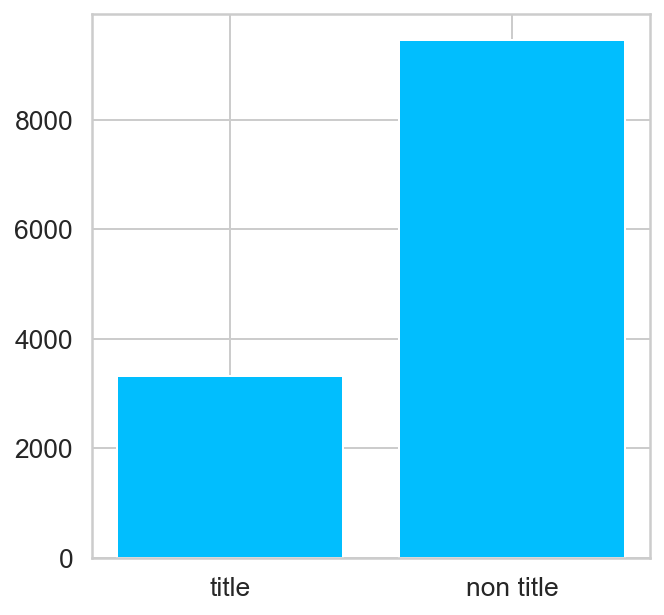

In [103]:
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(['title','non title'],[title_count,non_title_count])

Text(0.5, 0, 'number of token per sentence')

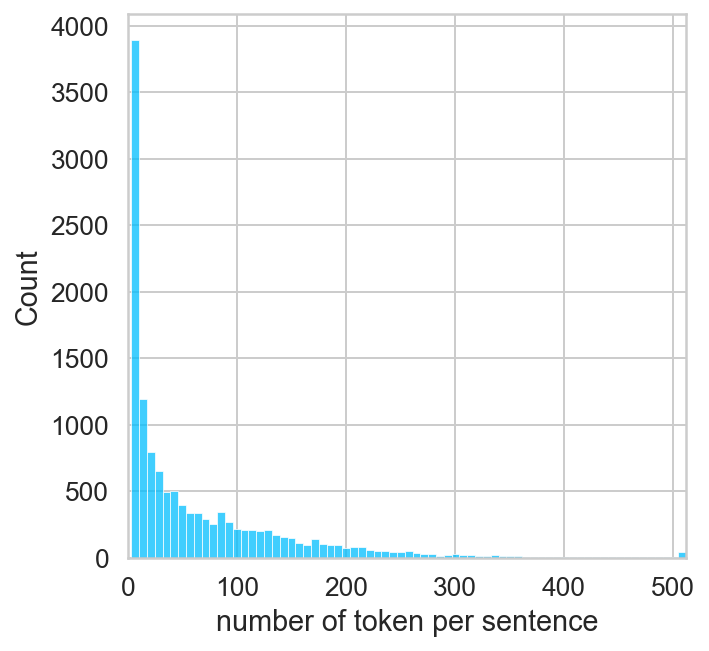

In [104]:
token_counts = []
for _, row in train.iterrows():
    token_count = len(tokenizer.encode(
    row["Text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512])
plt.xlabel("number of token per sentence")


In [105]:
token_counts_title = []
token_counts_non_title = []

for _, row in train.iterrows():
    token_count = len(tokenizer.encode(
        row["Text"],
        max_length=512,
        truncation=True
      ))
    if row["Label"]:
        token_counts_title.append(token_count)
    else:
        token_counts_non_title.append(token_count)


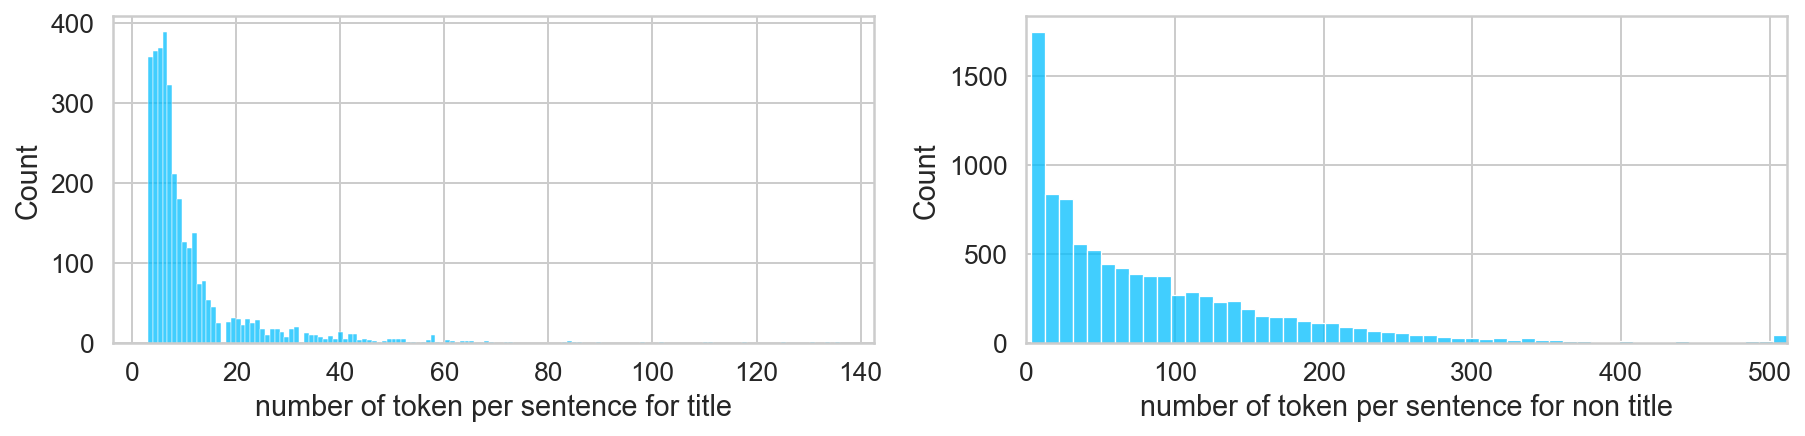

In [106]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
sns.histplot(token_counts_title,ax=axes[0])
sns.histplot(token_counts_non_title,ax=axes[1])
plt.xlim([0, 512])
axes[0].set_xlabel("number of token per sentence for title")
axes[1].set_xlabel("number of token per sentence for non title")
plt.show()

In [107]:
class TitleDetectionDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        text = data_row["Text"]
        others = list(data_row[1:-1])
        labels = [data_row["Label"]]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return dict(
            text=text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            others=torch.FloatTensor(others),
            labels=torch.FloatTensor(labels),
        )

In [108]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
MAX_TOKEN_COUNT = 128


In [109]:
train_dataset = pd.read_csv("train_cleaned.csv")
valid_dataset = pd.read_csv("valid_cleaned.csv")
test_dataset = pd.read_csv("test_cleaned.csv")
train_dataset = TitleDetectionDataset(
    train_dataset,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
valid_dataset = TitleDetectionDataset(
    valid_dataset,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
test_dataset = TitleDetectionDataset(
    test_dataset,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=16)
test_loader = DataLoader(test_dataset,batch_size=16)

In [110]:
class TitleDetection(nn.Module):
    def __init__(self, n_other_features, criterion=nn.BCELoss()):
        super(TitleDetection, self).__init__()
        self.bert = BertModel.from_pretrained(
            "bert-base-cased")
        self.ff1 = nn.Linear(
            self.bert.config.hidden_size + n_other_features, 1)
        self.criterion = criterion

    def forward(self, input_ids, attention_mask, others, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = output.pooler_output
        output = torch.cat((output, others), 1)
        output = self.ff1(output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    # Save and Load Functions

class TitleDetection_BertSequence(nn.Module):
    def __init__(self, n_other_features, criterion=nn.BCELoss()):
        super(TitleDetection_BertSequence, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(
            "bert-base-cased")
        self.ff1 = nn.Linear(
            2 + n_other_features, 1)
        self.criterion = criterion

    def forward(self, input_ids, attention_mask, others, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = torch.cat((output, others), 1)
        output = self.ff1(output)
        output = torch.sigmoid(output).to(torch.float)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output


def save_checkpoint(save_path, model, auroc):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'auroc': auroc}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):

    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['auroc']


def save_metrics(save_path, train_loss_list, valid_loss_list, auroc_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'auroc_list': auroc_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['auroc_list'], state_dict['global_steps_list']

In [111]:
def train(model,
          optimizer,
          train_loader=train_loader,
          valid_loader=test_loader,
          num_epochs=5,
          eval_every=len(train_loader) // 10,
          file_path="./experiment",
          best_auroc=float("-Inf"),
          patience=3
          ):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    roc_auc_list = []
#     for param in model.bert.parameters():
#             param.requires_grad = False
    # training loop
    not_improved = 0
    model.train()
    for epoch in range(num_epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                others = batch['others']
                labels = batch['labels']
                labels = labels.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                others = others.to(device)
                output = model(input_ids, attention_mask, others, labels)
                loss, _ = output
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item())

                # update running values
                running_loss += loss.item()
                global_step += 1

                # evaluation step
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():
                        y_pred = []
                        y_true = []
                        #  validation loop
                        for batch in valid_loader:
                            input_ids = batch['input_ids']
                            attention_mask = batch['attention_mask']
                            others = batch['others']
                            labels = batch['labels']
                            labels = labels.to(device)
                            input_ids = input_ids.to(device)
                            attention_mask = attention_mask.to(device)
                            others = others.to(device)
                #             titletext = titletext.type(torch.LongTensor)
                #             titletext = titletext.to(device)
                            output = model(
                                input_ids, attention_mask, others, labels)
                            loss, output = output
                            valid_running_loss += loss.item()
                            y_pred.extend(output.squeeze(1).tolist())
                            y_true.extend(labels.squeeze(1).tolist())

                    # evaluation
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(valid_loader)
                    train_loss_list.append(average_train_loss)
                    valid_loss_list.append(average_valid_loss)
                    global_steps_list.append(global_step)
                    roc_auc = roc_auc_score(y_true, y_pred)
                    roc_auc_list.append(roc_auc)

                    # resetting running values
                    running_loss = 0.0
                    valid_running_loss = 0.0
                    model.train()

                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, AUROC: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                  average_train_loss, average_valid_loss, roc_auc))

                    # checkpoint
                    if best_auroc < roc_auc:
                        best_auroc = roc_auc
                        save_checkpoint(file_path + '/' + 'model.pt',
                                        model, best_auroc)
                        save_metrics(file_path + '/' + 'metrics.pt',
                                     train_loss_list, valid_loss_list, roc_auc_list, global_steps_list)
                        not_improved = 0
                    else:
                        if not_improved >= patience:
                            print(
                                "The model has not been improved for a while, early stopped")
                            return
                        else:
                            not_improved += 1

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list,
                 valid_loss_list, roc_auc_list, global_steps_list)
    print('Finished Training!')

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TitleDetection(7).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
train(model=model, optimizer=optimizer, file_path='auroc')

  0%|          | 0/800 [00:00<?, ?batch/s]

Epoch [1/5], Step [80/4000], Train Loss: 0.3317, Valid Loss: 0.1788, AUROC: 0.9781
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [1/5], Step [160/4000], Train Loss: 0.1831, Valid Loss: 0.1559, AUROC: 0.9801
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [1/5], Step [240/4000], Train Loss: 0.1717, Valid Loss: 0.1544, AUROC: 0.9834
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [1/5], Step [320/4000], Train Loss: 0.1766, Valid Loss: 0.1344, AUROC: 0.9870
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [1/5], Step [400/4000], Train Loss: 0.1497, Valid Loss: 0.1176, AUROC: 0.9890
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [1/5], Step [480/4000], Train Loss: 0.1366, Valid Loss: 0.1084, AUROC: 0.9904
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [1/5], Step [560/4000], Train Loss: 0.1409, Valid Loss: 0.1047, AUROC: 

  0%|          | 0/800 [00:00<?, ?batch/s]

Epoch [2/5], Step [880/4000], Train Loss: 0.1076, Valid Loss: 0.1121, AUROC: 0.9913
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [2/5], Step [960/4000], Train Loss: 0.1231, Valid Loss: 0.0992, AUROC: 0.9917
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [2/5], Step [1040/4000], Train Loss: 0.1141, Valid Loss: 0.1020, AUROC: 0.9922
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [2/5], Step [1120/4000], Train Loss: 0.1022, Valid Loss: 0.0925, AUROC: 0.9917
Epoch [2/5], Step [1200/4000], Train Loss: 0.1012, Valid Loss: 0.0929, AUROC: 0.9928
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [2/5], Step [1280/4000], Train Loss: 0.1028, Valid Loss: 0.0850, AUROC: 0.9935
Model saved to ==> auroc/model.pt
Model saved to ==> auroc/metrics.pt
Epoch [2/5], Step [1360/4000], Train Loss: 0.0864, Valid Loss: 0.0938, AUROC: 0.9926
Epoch [2/5], Step [1440/4000], Train Loss: 0.1218, Valid 

  0%|          | 0/800 [00:00<?, ?batch/s]

Epoch [3/5], Step [1680/4000], Train Loss: 0.1039, Valid Loss: 0.0991, AUROC: 0.9917
The model has not been improved for a while, early stopped


  0%|          | 0/800 [00:00<?, ?batch/s]

Epoch [4/5], Step [1760/4000], Train Loss: 0.0679, Valid Loss: 0.0973, AUROC: 0.9919
The model has not been improved for a while, early stopped


  0%|          | 0/800 [00:00<?, ?batch/s]

Epoch [5/5], Step [1840/4000], Train Loss: 0.0792, Valid Loss: 0.1044, AUROC: 0.9923
The model has not been improved for a while, early stopped
Model saved to ==> auroc/metrics.pt
Finished Training!


In [95]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    wrong_sentence = []
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            for batch in tepoch:
#                 tepoch.set_description(f"Epoch {tepoch}")
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                others = batch['others']
                labels = batch['labels']
                labels = labels.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                others = others.to(device)
                output = model(input_ids, attention_mask, others, labels)
                _, output = output
                output[output>0.5] = 1
                output[output<0.5] = 0
                output = output.squeeze(1)
                labels = labels.squeeze(1)
                non_match = np.where(output!=labels)[0]
                text = np.array(batch['text'])
                if list(non_match):
                    wrong =  text[non_match]
                    features = others[non_match].tolist()
                    true_labels = labels[non_match].tolist()
                    one = list(zip(wrong,features,true_labels))
                    wrong_sentence.append(one)
                y_pred.extend(output.tolist())
                y_true.extend(labels.tolist())
    
    print ("wrong sentences examples\n" ,random.sample(wrong_sentence, 5))
    roc_auc = roc_auc_score(y_true, y_pred )
    print('Classification Report:')
    print ('AUROC: ', roc_auc)
    y_true
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Title', 'Non-Title'])
    ax.yaxis.set_ticklabels(['Title', 'Non-Title'])

  0%|          | 0/99 [00:00<?, ?batch/s]

wrong sentences examples
 [[('Andrew Keith Craddock', [0.0, 0.0, 0.0, -0.331781268119812, -1.089382529258728, -1.031014084815979, -1.1383377313613892], 1.0)], [('Carrying amount', [1.0, 0.0, 0.0, 0.4512971043586731, -1.0393980741500854, -0.35968726873397827, -0.4746514856815338], 0.0)], [('Strategic Report for the year ended 31 December 2016 (continued)', [1.0, 0.0, 0.0, -0.3585990369319916, -0.047484494745731354, -0.8929795026779175, -0.9942114949226379], 1.0), ('(c)', [0.0, 0.0, 0.0, -0.3585990369319916, -1.4422357082366943, -0.6734485030174255, -0.7881008982658386], 0.0), ('Financial Statement Schedule.', [0.0, 0.0, 0.0, 1.144982933998108, -0.817615270614624, 0.8841518759727478, 0.7393350005149841], 0.0)], [('Our acquisitions may expose us to significant unanticipated liabilities and could adversely affect our business, financial condition and results of operations.', [0.0, 1.0, 0.0, -0.4211737811565399, 0.3938596844673157, 0.3090927302837372, 0.17089299857616425], 0.0)], [("Success

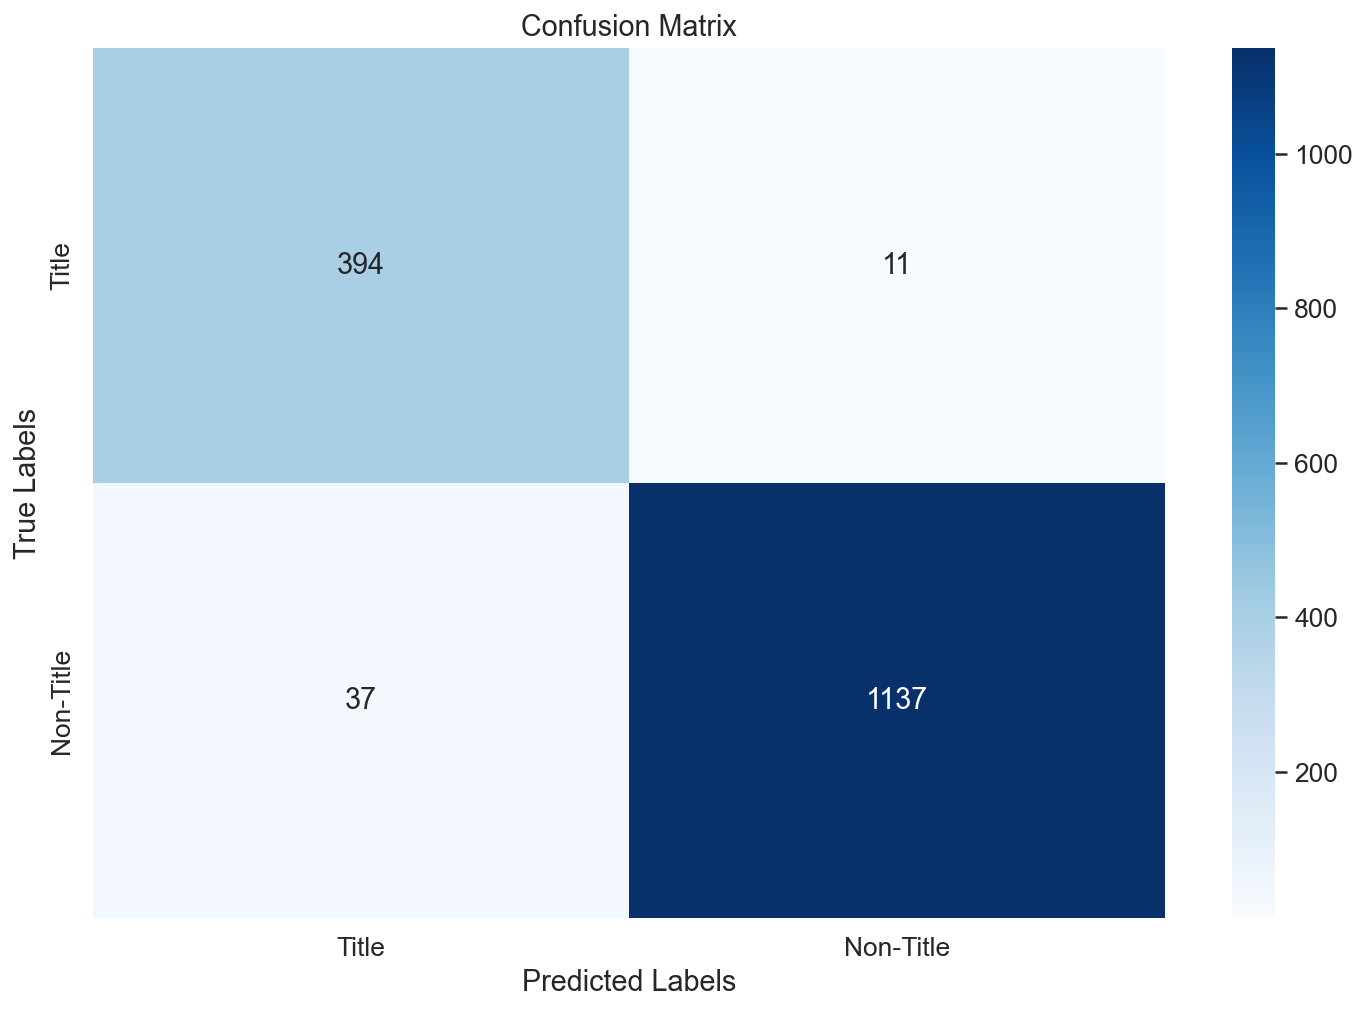

In [96]:
evaluate(best_model, test_loader)

In [98]:
best_model = TitleDetection_BertSequence(7).to(device)

load_checkpoint('./bertSequence' + '/model.pt', best_model)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Model loaded from <== ./bertSequence/model.pt


0.9926704103308305

  0%|          | 0/99 [00:00<?, ?batch/s]

wrong sentences examples
 [[('Disclosure of Information to Auditors', [1.0, 0.0, 0.0, -0.3585990369319916, -0.8535299897193909, 1.5305203199386597, 1.392438530921936], 0.0)], [('Property and equipment Intangible assets', [0.0, 0.0, 0.0, -0.16372336447238922, -1.158990502357483, 0.4771791100502014, 0.3916178047657013], 0.0)], [('Investigator-assessed', [1.0, 0.0, 0.0, 10.177202224731445, 0.9407265782356262, -0.9001104235649109, -1.0299910306930542], 0.0)], [('dressbarn', [1.0, 1.0, 0.0, -0.4211737811565399, -1.3741087913513184, 0.22555890679359436, 0.08875111490488052], 1.0)], [('-8', [1.0, 0.0, 0.0, -0.6786242127418518, -1.5151760578155518, -1.0203176736831665, -1.145392894744873], 1.0)]]
Classification Report:
AUROC:  0.9711737859381243
              precision    recall  f1-score   support

           1     0.9289    0.9679    0.9480       405
           0     0.9888    0.9744    0.9816      1174

    accuracy                         0.9728      1579
   macro avg     0.9588    0.9712 

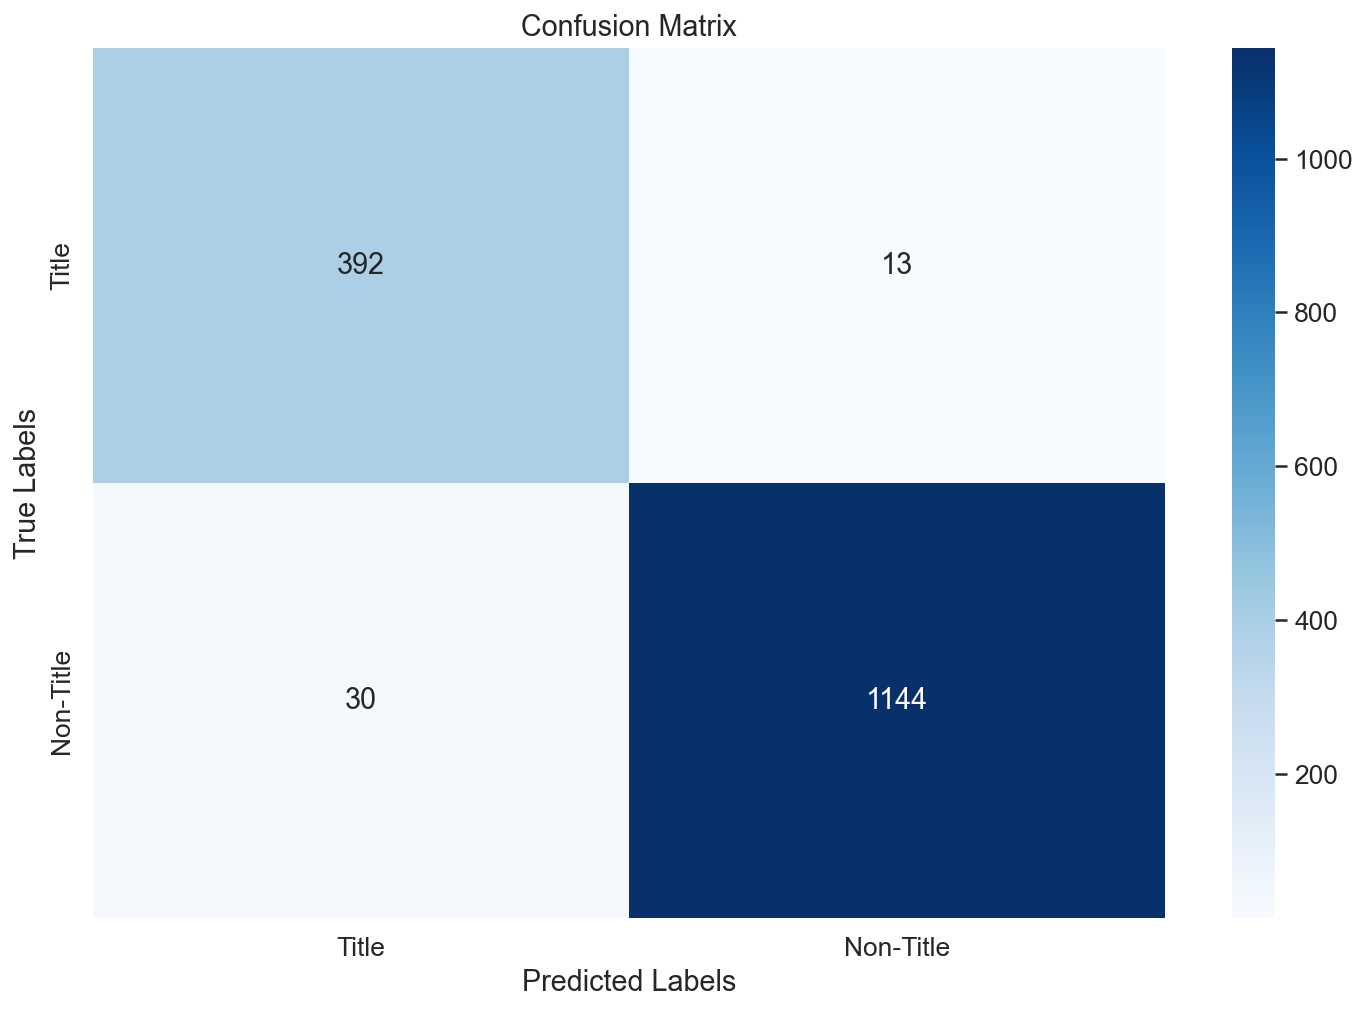

In [99]:
evaluate(best_model, test_loader)